# Experiment and path specification

In [9]:
# Specify the experiment for analysis
experiment='cxix40218'
runNumber = 15

# Set the installation and output path
import os
os.environ['INSTALLPATH']= '/cds/home/i/igabalsk/TRXS-Run18'
os.environ['OUTPUTPATH']= '/cds/data/psdm/%s/%s/scratch' % (experiment[0:3],experiment)

# Import Libraries

In [10]:
# Magic iPython command to enable plotting
%matplotlib inline

# Load in the pythonBatchMagic library
import sys
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic')
from pythonBatchMagic import *
# Determine current user
currentUser, error = unixCMD("echo $USER")
print(currentUser)
os.environ['RESULTSPATH']= ('/cds/data/psdm/%s/%s/results/%s' % (experiment[0:3],experiment,currentUser)).strip()
if not os.path.exists(os.environ['RESULTSPATH']):
    os.mkdir(os.environ['RESULTSPATH'])

igabalsk



# Leveraging the batch queue to quickly grab point data

## Loading libraries

In [11]:
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from LCLSdefault import *

sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/mattsTools')
from picklez import *

# Load in the get data library
from dataAnalysis import *

# Load in the batch library for lcls
from lclsBatch import *

# Load timebinned CSPAD

In [12]:
timebins = np.load(os.environ['RESULTSPATH']+'/timebins-run-%d.npy' % runNumber )
CSPAD = np.load(os.environ['RESULTSPATH']+'/CSPAD-run-%d.npy' % runNumber)
variance = np.load(os.environ['RESULTSPATH']+'/variance-run-%d.npy' % runNumber)
counts = np.load(os.environ['RESULTSPATH']+'/counts-run-%d.npy' % runNumber)


IOError: [Errno 2] No such file or directory: '/cds/data/psdm/cxi/cxix40218/results/igabalsk/timebins-run-15.npy'

# Plot CSPAD

In [5]:
CSPAD.shape

(8, 512, 1024, 10)

110.0


/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


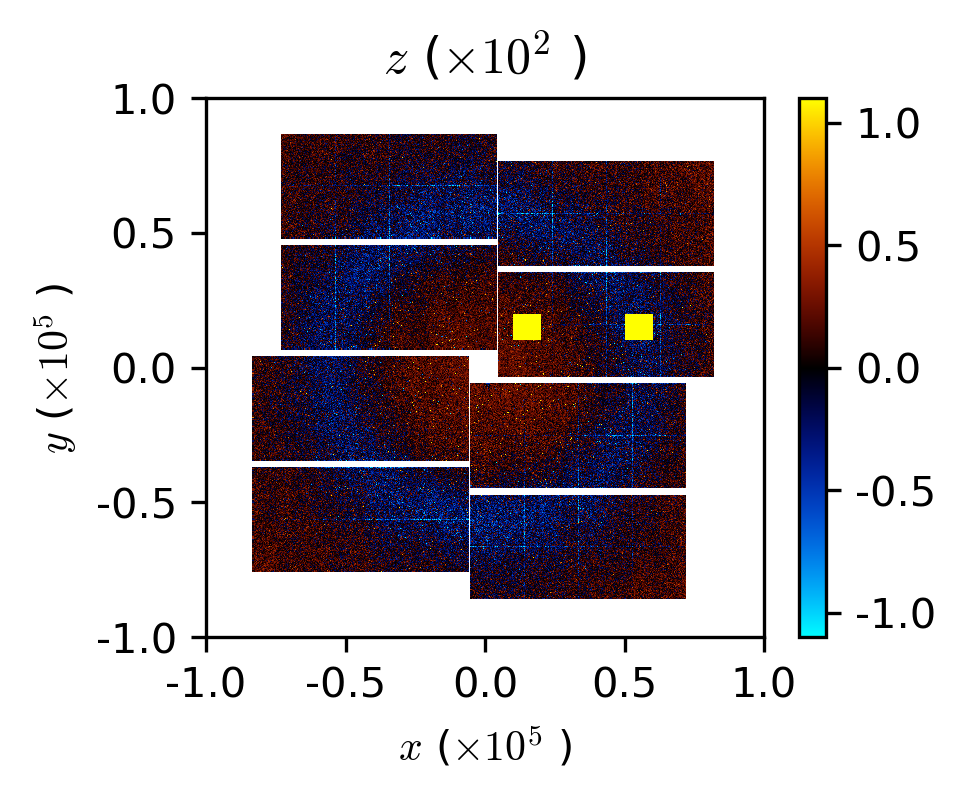

In [6]:
from IPython.display import clear_output
from plotStyles import *

def plotCSPAD( cspad , x , y, cspadMask=None, zLims = None, divergent=False, NTILE=8, ROIs=None ):
    figOpts = {'xLims':[-1e5,1e5],'yLims':[-1e5,1e5],'divergent':divergent, 'xIn':3, 'yIn':3*11.5/14.5}
    
    if zLims is not None:
        figOpts['zLims'] = zLims
    
    for iTile in range(NTILE):
    
        if cspadMask is not None:
            cspadTile = cspad[iTile,:,:]
            tileMask = ~cspadMask[iTile,:,:]
            cspadTile[tileMask] = 0
        if ROIs:
            for mask in ROIs:
                x0 = mask[0]
                y0 = mask[1]
                dx = mask[2]
                dy = mask[3]
                roimask = ( x0 < x[iTile] ) & ( (x0+dx) > x[iTile] ) & ( y0 < y[iTile] ) & ( (y0+dy) > y[iTile] )
                cspadTile[roimask] = 1000
        
        if iTile == 0:
            newFigure = True
        else:
            newFigure = False
        
        clear_output()
        colorPlot( x[iTile,:,:], y[iTile,:,:], cspadTile , newFigure=newFigure, **figOpts);


x,y = CSPADgeometry(detType='Jungfrau', run=runNumber, experiment=experiment)
# cspadMask = createMask(experiment=experiment, run=runNumber, detType='Jungfrau').astype(bool)
cspadMask = np.ones_like(x).astype(bool)
print(cspadMask.shape)


CSPADbinned = 1e7*np.copy(CSPAD)
CSPADbinned[CSPADbinned>10]=0
        
# plotCSPAD( cspadMask, x , y , cspadMask=cspadMask, divergent=True )
# plotCSPAD( np.sum(CSPADbinned[:,:,:,:100], axis=-1)-np.sum(CSPADbinned[:,:,:,100:200], axis=-1), x , y , cspadMask=cspadMask, divergent=False, NTILE=8 )
plotCSPAD( 3000*(CSPADbinned[:,:,:,2]-CSPADbinned[:,:,:,1]), x , y , zLims=[-100,100],
          cspadMask=cspadMask, divergent=True, NTILE=8, ROIs=[[1e4,1e4,1e4,1e4],[5e4,1e4,1e4,1e4]] )

# ROI analysis

Ignoring undefined input variable ...
[]


<ErrorbarContainer object of 3 artists>

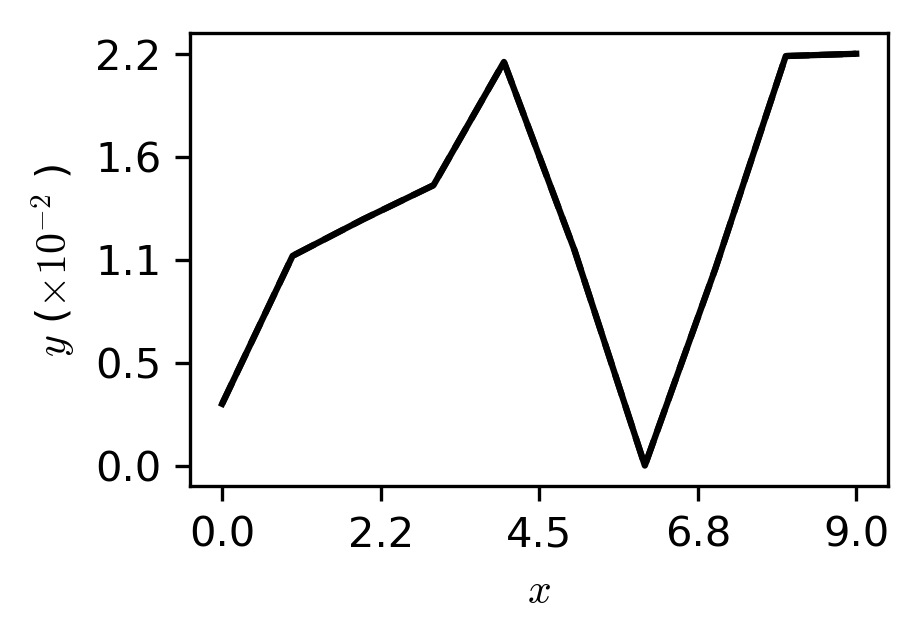

In [7]:
def roiSummed( x0, y0, dx, dy, x, y, image ):
    idx = ( x0 < x ) & ( (x0+dx) > x ) & ( y0 < y ) & ( (y0+dy) > y )
    return np.sum( image[idx , :] , 0 )

x0, y0 = 2e4, 2e4
x1, y1 = 4e4, 4e4
dx, dy = 1e4, 1e4


roi1 = roiSummed( x0, y0, dx, dy, x, y, CSPADbinned )
errroi1 = roiSummed( x0, y0, dx, dy, x, y, variance )
roi2 = roiSummed( x1, y1, dx, dy, x, y, CSPADbinned )
errroi2 = roiSummed( x1, y1, dx, dy, x, y, variance )

errorratio = 1/roi2*np.sqrt(errroi1)+roi1/roi2**2*np.sqrt(errroi2)


ratio = roi1/roi2
plotme = ratio[~np.isnan(ratio)]-ratio[~np.isnan(ratio)].min()
linePlot( timebins[~np.isnan(ratio)], plotme , newFigure = True)

plt.errorbar( timebins[~np.isnan(ratio)], plotme, yerr = errorratio[~np.isnan(ratio)] )

Ignoring undefined input variable ...
[]


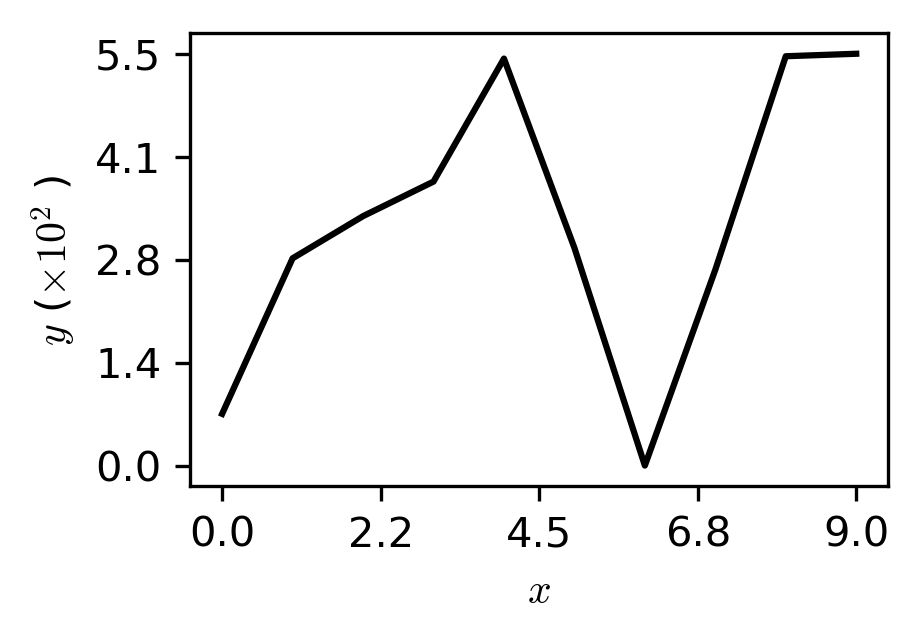

In [8]:
def roiSummed( x0, y0, dx, dy, x, y, image ):
    idx = ( x0 < x ) & ( (x0+dx) > x ) & ( y0 < y ) & ( (y0+dy) > y )
    return np.sum( image[idx , :] , 0 )

x0, y0 = 2e4, 2e4
x1, y1 = 4e4, 4e4
dx, dy = 1e4, 1e4


roi1 = roiSummed( x0, y0, dx, dy, x, y, CSPADbinned )
errroi1 = roiSummed( x0, y0, dx, dy, x, y, variance )
roi2 = roiSummed( x1, y1, dx, dy, x, y, CSPADbinned )
errroi2 = roiSummed( x1, y1, dx, dy, x, y, variance )

errorratio = 1/roi2*np.sqrt(errroi1)+roi1/roi2**2*np.sqrt(errroi2)

ratio = roi1
plotme = ratio[~np.isnan(ratio)]-ratio[~np.isnan(ratio)].min()
linePlot( timebins[~np.isnan(ratio)], plotme , newFigure = True)

# plt.errorbar( timebins[~np.isnan(ratio)], plotme, yerr = errorratio[~np.isnan(ratio)] )